In [10]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot encoding
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('/content/sample_data/mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9718 - loss: 0.0973
Test accuracy on clean images: 0.9753000140190125


In [11]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.0 MB/s eta 0:00:00


In [21]:
import foolbox as fb
import numpy as np
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))
# Выбор изображения для атаки (например, пятое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[9], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[9])
label = tf.convert_to_tensor(label, dtype=tf.int64)
# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=5, overshoot=0.01)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.001)  # Оборачиваем метку в тензор с размерностью (1,)

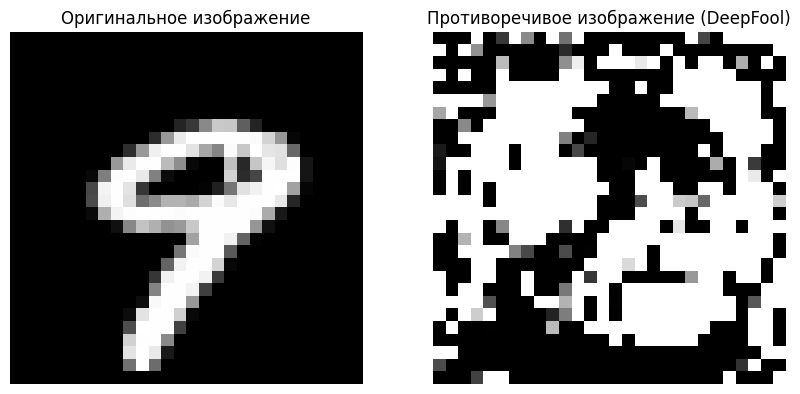

In [22]:
import matplotlib.pyplot as plt
# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

In [23]:
adversarial_images = []
# Обработка изображений
for i in range(len(test_images) // 10): # ограничил выборку для ускорения выполнения
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    # Атака на изображение
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)
# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)
# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0201 - loss: 69.4007
Accuracy on adversarial examples (CW attack): 0.027000000700354576
